### Install and Import Dependencies

In [ ]:
!pip install tsfresh

In [ ]:
import pandas as pd
import numpy as np
import tsfresh
from sklearn.model_selection import train_test_split, LeaveOneOut
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils import shuffle
import tensorflow as tf
import os
import itertools
import matplotlib.pyplot as plt

# keras goodies
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv1D, Dropout, MaxPooling1D, BatchNormalization, LSTM, SimpleRNN, ConvLSTM2D
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras import metrics as kmetrics
import tensorflow.keras.backend as K

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Respeck_recordings_clean.csv to Respeck_recordings_clean (1).csv


### Data Cleaning

In [ ]:
base_df = pd.read_csv('Respeck_recordings_clean (1).csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
len(base_df)

492675

In [ ]:
# Let's remove the general movement recordings
base_df = base_df[base_df['activity_type'] != 'Movement']
len(base_df)

457294

In [ ]:
base_df.reset_index(inplace=True)

In [ ]:
columns_of_interest = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']

In [ ]:
nan_indices = set()
for i in range(len(base_df)):
    for col in columns_of_interest:
        if pd.isnull(base_df.loc[i, col]):
            nan_indices.add(i)

In [ ]:
nan_indices

{315394}

In [ ]:
base_df.drop(list(nan_indices), inplace=True)

In [ ]:
# cleaning data
df_respeck = base_df[(base_df['activity_type']=='Standing') & (base_df['accel_y'] < -0.5)]
df_respeck = pd.concat([df_respeck, base_df[(base_df['activity_type']=='Walking at normal speed') & (base_df['accel_y'] < 0.5)]])
df_respeck = pd.concat([df_respeck, base_df[(base_df['activity_type']=='Climbing stairs') & (base_df['accel_y'] < 0)]])
df_respeck = pd.concat([df_respeck, base_df[(base_df['activity_type']=='Desk work') & (base_df['accel_y'] < -0.5)]])
df_respeck = pd.concat([df_respeck, base_df[(base_df['activity_type']=='Sitting') & (base_df['accel_y'] < -0.5)]])
df_respeck = pd.concat([df_respeck, base_df[(base_df['activity_type']=='Sitting bent forward') & (base_df['accel_y'] < -0.25)]])
df_respeck = pd.concat([df_respeck, base_df[(base_df['activity_type']=='Sitting bent backward') & (base_df['accel_y'] < 0)]])
df_respeck = pd.concat([df_respeck, base_df[(base_df['activity_type']=='Lying down on back')]])
df_respeck = pd.concat([df_respeck, base_df[(base_df['activity_type']=='Lying down on stomach')]])
df_respeck = pd.concat([df_respeck, base_df[(base_df['activity_type']=='Lying down left')]])
df_respeck = pd.concat([df_respeck, base_df[(base_df['activity_type']=='Lying down right')]])
df_respeck = pd.concat([df_respeck, base_df[(base_df['activity_type']=='Falling on the left')]])
df_respeck = pd.concat([df_respeck, base_df[(base_df['activity_type']=='Falling on the right')]])
df_respeck = pd.concat([df_respeck, base_df[(base_df['activity_type']=='Falling on knees')]])
df_respeck = pd.concat([df_respeck, base_df[(base_df['activity_type']=='Falling on the back')]])
df_respeck = pd.concat([df_respeck, base_df[(base_df['activity_type']=='Running')]])
base_df = pd.concat([df_respeck, base_df[(base_df['activity_type']=='Descending stairs') & (base_df['accel_x'] > -0.5) & (base_df['accel_y'] < 0.5)]])
#base_df.reset_index(inplace=True)

In [ ]:
base_df_Kai = base_df[base_df['subject_id'] == 's1800883']
base_df = base_df[base_df['subject_id'] != 's1800883']
#base_df_Kai.reset_index(inplace=True)
#base_df.reset_index(inplace=True)

Text(0.5, 1.0, 'Respeck - Descending stairs \n Gyroscope data')

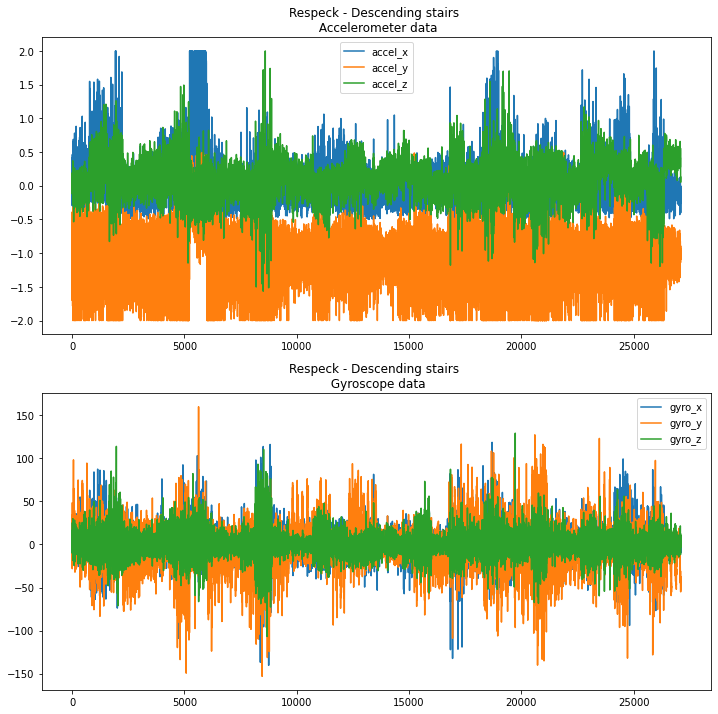

In [ ]:
df_respeck = base_df[base_df.activity_type == 'Descending stairs'].reset_index(drop=True)

fig, ax = plt.subplots(2, 1, figsize=(12, 12))

# plot respeck
ax[0].plot(df_respeck['accel_x'], label="accel_x")
ax[0].plot(df_respeck['accel_y'], label="accel_y")
ax[0].plot(df_respeck['accel_z'], label="accel_z")
ax[0].legend()

ax[0].set_title(f"{df_respeck['sensor_type'].values[0]} - {df_respeck['activity_type'].values[0]} \n Accelerometer data")

ax[1].plot(df_respeck['gyro_x'], label="gyro_x")
ax[1].plot(df_respeck['gyro_y'], label="gyro_y")
ax[1].plot(df_respeck['gyro_z'], label="gyro_z")
ax[1].legend()

ax[1].set_title(f"{df_respeck['sensor_type'].values[0]} - {df_respeck['activity_type'].values[0]} \n Gyroscope data")

In [ ]:
len(base_df)

434684

In [ ]:
base_df = base_df.reset_index()
base_df.drop(columns=['index'], inplace=True)

In [ ]:
base_df_Kai = base_df_Kai.reset_index()
base_df_Kai.drop(columns=['index'], inplace=True)

### Data Processing

In [ ]:
def dataProcessPipeline(base_df, window_size, step_size):
  window_number = 0
  all_overlapping_windows = []

  for rid, group in base_df.groupby("recording_id"):
    #print(f"Processing rid = {rid}")
    
    large_enough_windows = [window for window in group.rolling(window=window_size, min_periods=window_size) if len(window) == window_size]
    
    if len(large_enough_windows) == 0:
      continue

    overlapping_windows = large_enough_windows[::step_size] 
    
    # then we will append a window ID to each window
    for window in overlapping_windows:
        window.loc[:, 'window_id'] = window_number
        window_number += 1
    
    
    all_overlapping_windows.append(pd.concat(overlapping_windows).reset_index(drop=True))
  
  return all_overlapping_windows

In [ ]:
all_overlapping_windows = dataProcessPipeline(base_df, 50, 25)
all_overlapping_windows_test = dataProcessPipeline(base_df_Kai, 50, 25)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [ ]:
window_size = 50 # 50 datapoints for the window size, which, at 25Hz, means 2 seconds
step_size = 25 # this is 50% overlap

window_number = 0 # start a counter at 0 to keep track of the window number

all_overlapping_windows = []

for rid, group in base_df.groupby("recording_id"):

    print(f"Processing rid = {rid}")
    
    large_enough_windows = [window for window in group.rolling(window=window_size, min_periods=window_size) if len(window) == window_size]
    
    if len(large_enough_windows) == 0:
      continue

    overlapping_windows = large_enough_windows[::step_size] 
    
    # then we will append a window ID to each window
    for window in overlapping_windows:
        window.loc[:, 'window_id'] = window_number
        window_number += 1
    
    
    all_overlapping_windows.append(pd.concat(overlapping_windows).reset_index(drop=True))

In [ ]:
np.unique(base_df['activity_type'])

array(['Climbing stairs', 'Descending stairs', 'Desk work',
       'Falling on knees', 'Falling on the back', 'Falling on the left',
       'Falling on the right', 'Lying down left', 'Lying down on back',
       'Lying down on stomach', 'Lying down right', 'Running', 'Sitting',
       'Sitting bent backward', 'Sitting bent forward', 'Standing',
       'Walking at normal speed'], dtype=object)

In [ ]:
final_sliding_windows = pd.concat(all_overlapping_windows).reset_index(drop=True)

class_labels = {
    'Climbing stairs': 3,
    'Descending stairs': 3,
    'Desk work': 1,
    'Falling on knees': 0,
    'Falling on the back': 0,
    'Falling on the left': 0,
    'Falling on the right': 0,
    'Lying down left': 2,
    'Lying down on back': 2,
    'Lying down on stomach': 2,
    'Lying down right': 2,
    'Running': 4,
    'Sitting': 1,
    'Sitting bent backward': 1,
    'Sitting bent forward': 1,
    'Standing': 1,
    'Walking at normal speed': 3 
}

X = []
y = []

for window_id, group in final_sliding_windows.groupby('window_id'):
    #print(f"window_id = {window_id}")
    
    shape = group[columns_of_interest].values.shape
    #print(f"shape = {shape}")
    
    X.append(group[columns_of_interest].values)
    y.append(class_labels[group["activity_type"].values[0]])

    if class_labels[group["activity_type"].values[0]] == 0:
      #print("Oversampling...")
      for _ in range(80):
        X.append(group[columns_of_interest].values)
        y.append(class_labels[group["activity_type"].values[0]])
    if class_labels[group["activity_type"].values[0]] == 4:
      for _ in range(2):
        X.append(group[columns_of_interest].values)
        y.append(class_labels[group["activity_type"].values[0]])

X = np.asarray(X)
y = np.asarray(y)
X, y = shuffle(X, y)

print(f"X shape = {X.shape}")
print(f"y shape = {y.shape}")

X shape = (23784, 50, 6)
y shape = (23784,)


In [ ]:
X_test = []
y_test = []
final_sliding_windows_test = pd.concat(all_overlapping_windows_test).reset_index(drop=True)

for window_id, group in final_sliding_windows_test.groupby('window_id'):
    #print(f"window_id = {window_id}")
    
    shape = group[columns_of_interest].values.shape
    #print(f"shape = {shape}")
    
    X_test.append(group[columns_of_interest].values)
    y_test.append(class_labels[group["activity_type"].values[0]])

X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

print(f"X_test shape = {X_test.shape}")
print(f"y_test shape = {y_test.shape}")

X_test shape = (376, 50, 6)
y_test shape = (376,)


In [ ]:
for i in range(5):
  print(i, ": ", len(y[y==i]))

0 :  5427
1 :  5951
2 :  5296
3 :  3243
4 :  3867


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.1, train_size=0.9)

y_train = np.asarray(pd.get_dummies(y_train), dtype=np.float32)
y_test = np.asarray(pd.get_dummies(y_test), dtype=np.float32)

In [ ]:
print(f"X_train shape = {X_train.shape}")
print(f"y_train shape = {y_train.shape}")

print(f"X_test shape = {X_test.shape}")
print(f"y_test shape = {y_test.shape}")

X_train shape = (21405, 50, 6)
y_train shape = (21405, 5)
X_test shape = (2379, 50, 6)
y_test shape = (2379, 5)


### Model Training (CNN)

In [ ]:
window_size = 50 # 50 datapoints for the window size, which, at 25Hz, means 2 seconds
step_size = 25 # this is 50% overlap

filters = 64
kernel_size = 3
n_features = 6
activation='relu'
n_classes = 5

model = Sequential()

model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='linear', 
                 input_shape=(window_size, n_features)))
model.add(BatchNormalization())
model.add(Activation(activation))

model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='linear'))
model.add(BatchNormalization())
model.add(Activation(activation))

model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='linear'))
model.add(BatchNormalization())
model.add(Activation(activation))

model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 48, 64)            1216      
                                                                 
 batch_normalization (BatchN  (None, 48, 64)           256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 48, 64)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 46, 64)            12352     
                                                                 
 batch_normalization_1 (Batc  (None, 46, 64)           256       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 46, 64)           

In [ ]:
model.compile(
    optimizer=optimizers.SGD(lr=0.001),
    loss='binary_crossentropy',
    metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
model.fit(X_train, y_train,
        batch_size=16, epochs=25)

Epoch 1/25
1338/1338 [==============================] - 17s 11ms/step - loss: 0.3760 - accuracy: 0.5388
Epoch 2/25
1338/1338 [==============================] - 15s 11ms/step - loss: 0.2615 - accuracy: 0.6711
Epoch 3/25
1338/1338 [==============================] - 15s 11ms/step - loss: 0.2280 - accuracy: 0.7262
Epoch 4/25
1338/1338 [==============================] - 15s 11ms/step - loss: 0.2084 - accuracy: 0.7507
Epoch 5/25
1338/1338 [==============================] - 15s 11ms/step - loss: 0.1971 - accuracy: 0.7716
Epoch 6/25
1338/1338 [==============================] - 15s 11ms/step - loss: 0.1870 - accuracy: 0.7985
Epoch 7/25
1338/1338 [==============================] - 15s 11ms/step - loss: 0.1788 - accuracy: 0.8398
Epoch 8/25
1338/1338 [==============================] - 15s 11ms/step - loss: 0.1648 - accuracy: 0.8874
Epoch 9/25
1338/1338 [==============================] - 15s 11ms/step - loss: 0.1338 - accuracy: 0.9263
Epoch 10/25
1338/1338 [==============================] - 15s 11m

In [ ]:
# stats for five classes
y_pred_ohe = model.predict(X_test)
y_pred_labels = np.argmax(y_pred_ohe, axis=1)
#y_true_labels = np.argmax(y_test, axis=1)
print("*" * 80)
print("Classification report")
print("*" * 80)
print(classification_report(y_test, y_pred_labels))
#print(classification_report(y_true_labels, y_pred_labels))

********************************************************************************
Classification report
********************************************************************************
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       145
           2       1.00      1.00      1.00       116
           3       1.00      0.99      0.99        86
           4       0.97      1.00      0.98        29

    accuracy                           1.00       376
   macro avg       0.99      1.00      0.99       376
weighted avg       1.00      1.00      1.00       376



In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model_cnn.tflite', 'wb') as f:
  f.write(tflite_model)

from google.colab import files
files.download('model_cnn.tflite')

INFO:tensorflow:Assets written to: /tmp/tmptdg7t0ev/assets


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Model Training (ConvLSTM)

In [ ]:
# reshape into subsequences (samples, time steps, rows, cols, channels)
n_steps, n_length = 2, 25
X_train = X_train.reshape((X_train.shape[0], n_steps, 1, n_length, n_features))
X_test = X_test.reshape((X_test.shape[0], n_steps, 1, n_length, n_features))

# the ConvLSTM Network Model for the top hierarchy

model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_2 (ConvLSTM2D)  (None, 1, 23, 64)         54016     
                                                                 
 dropout_2 (Dropout)         (None, 1, 23, 64)         0         
                                                                 
 flatten_3 (Flatten)         (None, 1472)              0         
                                                                 
 dense_6 (Dense)             (None, 100)               147300    
                                                                 
 dense_7 (Dense)             (None, 5)                 505       
                                                                 
Total params: 201,821
Trainable params: 201,821
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train, y_train, epochs=8, batch_size=32)

Epoch 1/8
669/669 [==============================] - 22s 29ms/step - loss: 0.2514 - accuracy: 0.9258
Epoch 2/8
669/669 [==============================] - 20s 29ms/step - loss: 0.0626 - accuracy: 0.9792
Epoch 3/8
669/669 [==============================] - 20s 29ms/step - loss: 0.0535 - accuracy: 0.9817
Epoch 4/8
669/669 [==============================] - 20s 30ms/step - loss: 0.0408 - accuracy: 0.9851
Epoch 5/8
669/669 [==============================] - 19s 29ms/step - loss: 0.0441 - accuracy: 0.9862
Epoch 6/8
669/669 [==============================] - 19s 29ms/step - loss: 0.0260 - accuracy: 0.9909
Epoch 7/8
669/669 [==============================] - 19s 29ms/step - loss: 0.0330 - accuracy: 0.9903
Epoch 8/8
669/669 [==============================] - 19s 29ms/step - loss: 0.0205 - accuracy: 0.9939


In [ ]:
# stats for five classes
y_pred_ohe = model.predict(X_test)
#y_pred_labels = np.argmax(y_pred_ohe, axis=1)
y_true_labels = np.argmax(y_test, axis=1)
print("*" * 80)
print("Classification report")
print("*" * 80)
#print(classification_report(y_test, y_pred_labels))
print(classification_report(y_true_labels, y_pred_labels))

********************************************************************************
Classification report
********************************************************************************
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       561
           1       1.00      1.00      1.00       614
           2       1.00      0.99      1.00       511
           3       0.99      0.98      0.99       296
           4       0.98      1.00      0.99       397

    accuracy                           0.99      2379
   macro avg       0.99      0.99      0.99      2379
weighted avg       0.99      0.99      0.99      2379



In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
#converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
#converter._experimental_lower_tensor_list_ops = False
tflite_model = converter.convert()

# Save the model.
with open('model_conv_lstm.tflite', 'wb') as f:
  f.write(tflite_model)

from google.colab import files
files.download('model_conv_lstm.tflite')

INFO:tensorflow:Assets written to: /tmp/tmp3egvh8cq/assets


INFO:tensorflow:Assets written to: /tmp/tmp3egvh8cq/assets


ConverterError: ignored

### Model Training (LSTM)

In [ ]:
units = 100
filters = 64
kernel_size = 3
n_features = 6
activation='relu'
n_classes = 5

model_lstm = Sequential()

model_lstm.add(LSTM(units=units, input_shape=(window_size, n_features)))
model_lstm.add(Dense(100, activation='relu'))
model_lstm.add(Dense(n_classes, activation='softmax'))

model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               42800     
                                                                 
 dense (Dense)               (None, 100)               10100     
                                                                 
 dense_1 (Dense)             (None, 5)                 505       
                                                                 
Total params: 53,405
Trainable params: 53,405
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_lstm.compile(
    optimizer=optimizers.SGD(lr=0.001),
    loss='binary_crossentropy',
    metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
model_lstm.fit(X_train, y_train,
        batch_size=10, epochs=50)

Epoch 1/50
1938/1938 [==============================] - 52s 26ms/step - loss: 0.5905 - accuracy: 0.3573
Epoch 2/50
1938/1938 [==============================] - 49s 25ms/step - loss: 0.4996 - accuracy: 0.5663
Epoch 3/50
1938/1938 [==============================] - 49s 25ms/step - loss: 0.4392 - accuracy: 0.5662
Epoch 4/50
1938/1938 [==============================] - 50s 26ms/step - loss: 0.3917 - accuracy: 0.5771
Epoch 5/50
1938/1938 [==============================] - 49s 25ms/step - loss: 0.3554 - accuracy: 0.5871
Epoch 6/50
1938/1938 [==============================] - 49s 25ms/step - loss: 0.3292 - accuracy: 0.5924
Epoch 7/50
1938/1938 [==============================] - 49s 25ms/step - loss: 0.3095 - accuracy: 0.6126
Epoch 8/50
1938/1938 [==============================] - 50s 26ms/step - loss: 0.2930 - accuracy: 0.6765
Epoch 9/50
1938/1938 [==============================] - 49s 25ms/step - loss: 0.2775 - accuracy: 0.7345
Epoch 10/50
1938/1938 [==============================] - 50s 26m

In [ ]:
# stats for five classes
y_pred_ohe = model_lstm.predict(X_test)
y_pred_labels = np.argmax(y_pred_ohe, axis=1)
y_true_labels = np.argmax(y_test, axis=1)
print("*" * 80)
print("Classification report")
print("*" * 80)
print(classification_report(y_true_labels, y_pred_labels))

********************************************************************************
Classification report
********************************************************************************
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1104
           1       0.98      0.98      0.98      1242
           2       0.98      0.97      0.98      1052
           3       0.95      0.93      0.94       649
           4       0.96      0.98      0.97       797

    accuracy                           0.97      4844
   macro avg       0.97      0.97      0.97      4844
weighted avg       0.97      0.97      0.97      4844



In [ ]:
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               42800     
                                                                 
 dense (Dense)               (None, 100)               10100     
                                                                 
 dense_1 (Dense)             (None, 5)                 505       
                                                                 
Total params: 53,405
Trainable params: 53,405
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model_lstm)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
tflite_model = converter.convert()

# Save the model.
with open('model_lstm.tflite', 'wb') as f:
  f.write(tflite_model)

from google.colab import files
files.download('model_lstm.tflite')

INFO:tensorflow:Assets written to: /tmp/tmpe78bbrif/assets


INFO:tensorflow:Assets written to: /tmp/tmpe78bbrif/assets


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>